<a href="https://colab.research.google.com/github/amyDing629/AI-ML-DL/blob/main/image-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import skimage.io, skimage.color
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy import ndimage
import math

In [ ]:
# mount your google drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


Q3

In [ ]:
def calculate_gradient(img, template):
    ts = template.size #Number of elements in the template (3).
    #New padded array to hold the resultant gradient image.
    new_img = np.zeros((img.shape[0]+ts-1, 
                           img.shape[1]+ts-1))
    new_img[np.uint16((ts-1)/2.0):img.shape[0]+np.uint16((ts-1)/2.0), 
            np.uint16((ts-1)/2.0):img.shape[1]+np.uint16((ts-1)/2.0)] = img
    result = np.zeros((new_img.shape))
    
    for r in np.uint16(np.arange((ts-1)/2.0, img.shape[0]+(ts-1)/2.0)):
        for c in np.uint16(np.arange((ts-1)/2.0, 
                              img.shape[1]+(ts-1)/2.0)):
            curr_region = new_img[r-np.uint16((ts-1)/2.0):r+np.uint16((ts-1)/2.0)+1, 
                                  c-np.uint16((ts-1)/2.0):c+np.uint16((ts-1)/2.0)+1]
            curr_result = curr_region * template
            score = np.sum(curr_result)
            result[r, c] = score
    #Result of the same size as the original image after removing the padding.
    result_img = result[np.uint16((ts-1)/2.0):result.shape[0]-np.uint16((ts-1)/2.0), 
                        np.uint16((ts-1)/2.0):result.shape[1]-np.uint16((ts-1)/2.0)]
    return result_img

def gradient_magnitude(horizontal_gradient, vertical_gradient):
    horizontal_gradient_square = np.power(horizontal_gradient, 2)
    vertical_gradient_square = np.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    grad_magnitude = np.sqrt(sum_squares)
    return grad_magnitude

def gradient_direction(horizontal_gradient, vertical_gradient):
    grad_direction = np.arctan(vertical_gradient/(horizontal_gradient+0.00000001)) # Avoid divided by 0
    grad_direction = np.rad2deg(grad_direction)
    grad_direction = grad_direction%180
    return grad_direction

def check_angle(angle):
  # return the corresponding bin number of the angle
  if angle < 15 or angle > 165:
    return 0
  if angle >= 15 and angle < 45:
    return 1
  if angle >= 45 and angle < 75:
    return 2
  if angle >= 75 and angle < 105:
    return 3
  if angle >= 105 and angle < 135:
    return 4
  if angle >= 135 and angle < 165:
    return 5
    
def cell_count(grad_direction, cell_length):
  res = np.zeros(6)
  for i in range(cell_length):
    for j in range(cell_length):
      index = check_angle(grad_direction[i][j])
      res[index] += 1
  return res

def accumulated_gradient(grad_direction, grad_magnitude, cell_length):
  res = np.zeros(6)
  for i in range(cell_length):
    for j in range(cell_length):
      index = check_angle(grad_direction[i][j])
      res[index] += grad_magnitude[i][j]
  return res

def generate_grid_cell(img, is_cell_count, cell_length, grad_direction, grad_magnitude):
  grid_width = img.shape[0]//cell_length - 1
  grid_length = img.shape[1]//cell_length - 1

  grid = np.zeros((grid_width, grid_length, 6))
  grid = list(grid)
  for i in range(grid_width):
    for j in range(grid_length):
      cell_direction = grad_direction[i*cell_length:(i+1)*cell_length, j*cell_length:(j+1)*cell_length]
      cell_magnitude = grad_magnitude[i*cell_length:(i+1)*cell_length, j*cell_length:(j+1)*cell_length]

      if is_cell_count:
        grid_result = cell_count(cell_direction, cell_length)
      else:
        grid_result = accumulated_gradient(cell_direction, cell_magnitude, cell_length)
      
      for num in range(6):
        grid[i][j][num] += grid_result[num]
  return np.array(grid)
    

In [ ]:
def generate_grid(img, is_cell_count, threshold, cell_length):
  horizontal_mask = np.array([-1, 0, 1])
  vertical_mask = np.array([[-1],
                              [0],
                              [1]])

  horizontal_gradient = calculate_gradient(img, horizontal_mask)
  vertical_gradient = calculate_gradient(img, vertical_mask)

  grad_magnitude = gradient_magnitude(horizontal_gradient, vertical_gradient)
  grad_direction = gradient_direction(horizontal_gradient, vertical_gradient)

  # Apply threshold
  for i in range(grad_magnitude.shape[0]):
    for j in range(grad_magnitude.shape[1]):
      if grad_magnitude[i][j] < threshold:
        grad_magnitude[i][j] = 0
  
  return generate_grid_cell(img, is_cell_count, cell_length, grad_direction, grad_magnitude)

def visualize(img, grid, is_normalize, cell_length):
  bin1 = np.zeros((grid.shape[0], grid.shape[1]))
  bin2 = np.zeros((grid.shape[0], grid.shape[1]))
  bin3 = np.zeros((grid.shape[0], grid.shape[1]))
  bin4 = np.zeros((grid.shape[0], grid.shape[1]))
  bin5 = np.zeros((grid.shape[0], grid.shape[1]))
  bin6 = np.zeros((grid.shape[0], grid.shape[1]))
  
  for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
      if not is_normalize:
        bin1[i][j] = grid[i][j][0]
        bin2[i][j] = grid[i][j][1]
        bin3[i][j] = grid[i][j][2]
        bin4[i][j] = grid[i][j][3]
        bin5[i][j] = grid[i][j][4]
        bin6[i][j] = grid[i][j][5]
      else:
        bin1[i][j] = grid[i][j][0] + grid[i][j][6] + grid[i][j][12] + grid[i][j][18]
        bin2[i][j] = grid[i][j][1] + grid[i][j][7] + grid[i][j][13] + grid[i][j][19]
        bin3[i][j] = grid[i][j][2] + grid[i][j][8] + grid[i][j][14] + grid[i][j][20]
        bin4[i][j] = grid[i][j][3] + grid[i][j][9] + grid[i][j][15] + grid[i][j][21]
        bin5[i][j] = grid[i][j][4] + grid[i][j][10] + grid[i][j][16] + grid[i][j][22]
        bin6[i][j] = grid[i][j][5] + grid[i][j][11] + grid[i][j][17] + grid[i][j][23]

  x = np.linspace(0,grid.shape[1]*cell_length,grid.shape[1])
  y = np.linspace(0,grid.shape[0]*cell_length,grid.shape[0])
  X, Y = np.meshgrid(x, y)
  plt.imshow(img, cmap=plt.cm.gray)
  plt.quiver(X, Y, bin1*math.sin(math.radians(0)), bin1*math.cos(math.radians(0)), headwidth=0, headlength=0, color='red', width=0.003, pivot='middle')
  plt.quiver(X, Y, bin2*math.sin(math.radians(30)), bin2*math.cos(math.radians(30)), headwidth=0, headlength=0, color='red', width=0.003, pivot='middle')
  plt.quiver(X, Y, bin3*math.sin(math.radians(60)), bin3*math.cos(math.radians(60)), headwidth=0, headlength=0, color='red', width=0.003, pivot='middle')
  plt.quiver(X, Y, bin4*math.sin(math.radians(90)), bin4*math.cos(math.radians(90)), headwidth=0, headlength=0, color='red', width=0.003, pivot='middle')
  plt.quiver(X, Y, bin5*math.sin(math.radians(120)), bin5*math.cos(math.radians(120)), headwidth=0, headlength=0, color='red', width=0.003, pivot='middle')
  plt.quiver(X, Y, bin6*math.sin(math.radians(150)), bin6*math.cos(math.radians(150)), headwidth=0, headlength=0, color='red', width=0.003, pivot='middle')

def normalize(grid):
  normalized_hog = np.zeros((grid.shape[0]-1, grid.shape[1]-1, 24))
  for i in range(grid.shape[0] - 1):
    for j in range(grid.shape[1] - 1):
      entries = list(grid[i][j]) + list(grid[i+1][j]) + list(grid[i][j+1]) + list(grid[i+1][j+1])
      for entry_index in range(len(entries)):
          entries[entry_index] = entries[entry_index]/((sum(np.array(entries)**2)+0.001**2)**0.5)
      normalized_hog[i][j] = entries
  return normalized_hog

def save_to_txt(txt_name, histo):
  histo = histo.reshape((histo.shape[0]*histo.shape[1],  histo.shape[2]))
  np.savetxt(txt_name, histo)

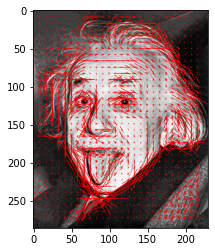

In [ ]:
threshold = 15
cell_length = 8
img = cv2.imread("/content/drive/My Drive/1.jpg", cv2.IMREAD_GRAYSCALE)
is_count = False
is_normalize = False
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)
save_to_txt("/content/drive/My Drive/1.txt", normalize(grid))

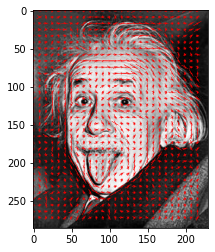

In [ ]:
is_count = True
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)

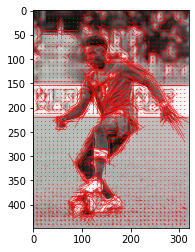

In [ ]:
img = cv2.imread("/content/drive/My Drive/2.jpg", cv2.IMREAD_GRAYSCALE)
is_count = False
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)
save_to_txt("/content/drive/My Drive/2.txt", normalize(grid))

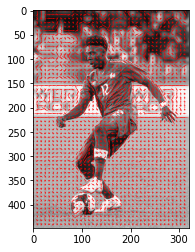

In [ ]:
is_count = True
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)

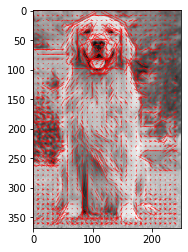

In [ ]:
img = cv2.imread("/content/drive/My Drive/3.jpg", cv2.IMREAD_GRAYSCALE)
is_count = False
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)
save_to_txt("/content/drive/My Drive/3.txt", normalize(grid))

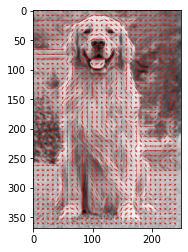

In [ ]:
is_count = True
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)

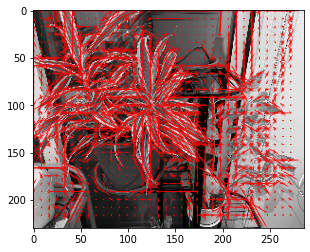

In [ ]:
import cv2
img = cv2.imread("/content/drive/My Drive/5.jpeg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, dsize=(286, 230), interpolation=cv2.INTER_CUBIC)
is_count = False
is_normalize = False
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)


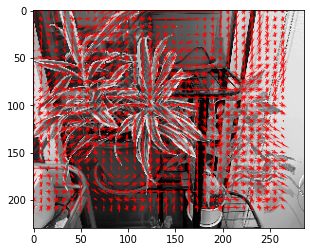

In [ ]:
grid = normalize(grid)
is_normalize = True
visualize(img, grid, is_normalize, cell_length)
save_to_txt("/content/drive/My Drive/unflashed.txt", grid)

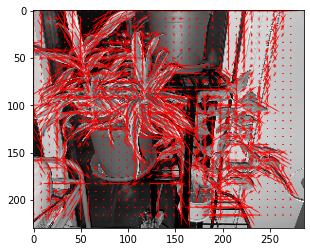

In [ ]:
img = cv2.imread("/content/drive/My Drive/6.jpeg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, dsize=(286, 230), interpolation=cv2.INTER_CUBIC)
is_count = False
is_normalize = False
grid = generate_grid(img, is_count, threshold, cell_length)
visualize(img, grid, is_normalize, cell_length)


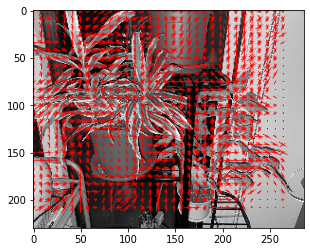

In [ ]:
grid = normalize(grid)
is_normalize = True
visualize(img, grid, is_normalize, cell_length)
save_to_txt("/content/drive/My Drive/flashed.txt", grid)

Q4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install opencv-python
import cv2
import math
from PIL import Image
from numpy import linalg as la

In [ ]:
def SecondMomentMatrix(image, window):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blur = cv2.GaussianBlur(gray,(5,5),7)
    Ix = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)

    IxIy = np.multiply(Ix, Iy)
    Ix2 = np.multiply(Ix, Ix)
    Iy2 = np.multiply(Iy, Iy)

    Ix2_blur = cv2.GaussianBlur(Ix2,(7,7),10)
    Iy2_blur = cv2.GaussianBlur(Iy2,(7,7),10)
    IxIy_blur = cv2.GaussianBlur(IxIy,(7,7),10)

    lambda0 = np.zeros(gray.shape)
    lambda1 = np.zeros(gray.shape)
    for x in range(image.shape[0] - window.shape[0]):
        for y in range(image.shape[1] - window.shape[1]):
            #calculate every M matrix
            M_matrix = [[0, 0], [0, 0]]
            for m in range(window.shape[0]):
                for n in range(window.shape[1]):
                    temp_matrix = np.array([[Ix2_blur[x+m][y+n], IxIy_blur[x+m][y+n]], [IxIy_blur[x+m][y+n], Iy2_blur[x+m][y+n]]])
                    M_matrix += window[m][n] * temp_matrix
            #find the eigenvalues:
            eigvals, eigvecs = la.eig(M_matrix)
            eigvals = eigvals.real
            lambda0[x][y] = eigvals[0]
            lambda1[x][y] = eigvals[1]
    return lambda0, lambda1

In [ ]:
def gkern(w, l, sig):
    """
    parameters:
    w: width of the filter matrix
    l: length of the filter matrix
    sig: scale
    Return 2D guassian matrix with widthw and length l, scale sig.
    """
    # Return number of l evenly spaced numbers over the ientrval represents w and l in formula
    w = np.linspace(-(w-1), w-1, w)
    l = np.linspace(-(l-1), l-1, l)

    # create saparate filter of w and l
    gauss_w = np.exp(-np.square(w)/ np.square(sig)) * math.sqrt((2*math.pi*np.square(sig)))
    gauss_l = np.exp(-np.square(l)/ np.square(sig)) * math.sqrt((2*math.pi*np.square(sig)))

    # multiply two part together to get gaussian filter 
    gauss = np.outer(gauss_w, gauss_l)
    return gauss / np.sum(gauss)

In [ ]:
def calculate_eigenvalues(img, sigma):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  kernel = gkern(3,3,sigma)
  return SecondMomentMatrix(img, kernel)

img1 = cv2.imread("/content/drive/My Drive/Sandford_Fleming_Building_2011_Toronto.jpg")
img2 = cv2.imread("/content/drive/My Drive/Uoft_SF-01.jpg")
sigma = 1
lam0_img1_k1, lam1_img1_k1 = calculate_eigenvalues(img1, sigma)
lam0_img2_k1, lam1_img2_k1 = calculate_eigenvalues(img2, sigma)

Text(0, 0.5, 'lambda2_k1')

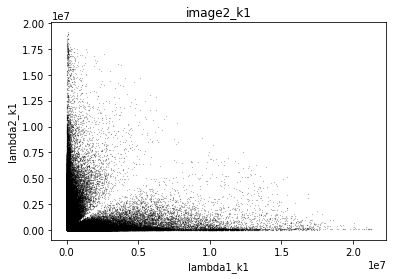

In [ ]:
plt.scatter(lam0_img1_k1, lam1_img1_k1, c='black', s=0.01)
plt.title("image2_k1")
plt.xlabel("lambda1_k1")
plt.ylabel("lambda2_k1")

Text(0, 0.5, 'lambda2_k1')

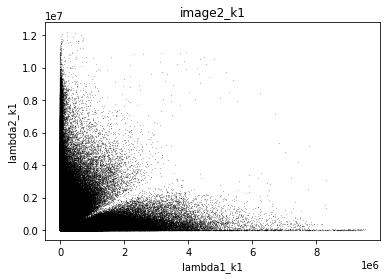

In [ ]:
plt.scatter(lam0_img2_k1, lam1_img2_k1, c='black', s=0.01)
plt.title("image2_k1")
plt.xlabel("lambda1_k1")
plt.ylabel("lambda2_k1")

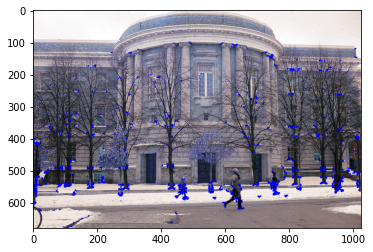

In [ ]:
def plot(img, threshold, lam1, lam2):
    mylist = []
    # lam0_img1.shape
    for i in range(img.shape[0]):
      inside = []
      for j in range(img.shape[1]):
        minimum = min(lam1[i][j], lam2[i][j])
        inside.append(minimum)
      mylist.append(inside)
    mat = np.array(mylist)
    img_temp = img.copy()
    img_temp[mat>threshold]=[0,0,255]
    plt.imshow(img_temp)

threshold = 500000
plot(img1, threshold, lam0_img1_k1, lam1_img1_k1)

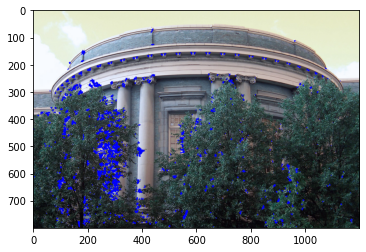

In [ ]:
plot(img2, threshold, lam0_img2_k1, lam1_img2_k1)

In [ ]:
#Generate a Gaussian kernel with sigma = 10000
kernel2 = gkern(3,3,10000)
#for image1:
lam0_img1_k2, lam1_img1_k2 = SecondMomentMatrix(img1, kernel2)
#for image2:
lam0_img2_k2, lam1_img2_k2 = SecondMomentMatrix(img2, kernel2)

KeyboardInterrupt: ignored

Text(0, 0.5, 'lambda2_k2')

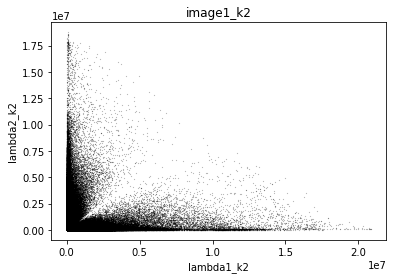

In [ ]:
plt.scatter(lam0_img1_k2, lam1_img1_k2, c='black', s=0.01)
plt.title("image1_k2")
plt.xlabel("lambda1_k2")
plt.ylabel("lambda2_k2")

Text(0, 0.5, 'lambda2_k2')

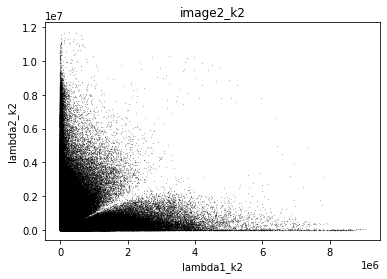

In [ ]:
plt.scatter(lam0_img2_k2, lam1_img2_k2, c='black', s=0.01)
plt.title("image2_k2")
plt.xlabel("lambda1_k2")
plt.ylabel("lambda2_k2")

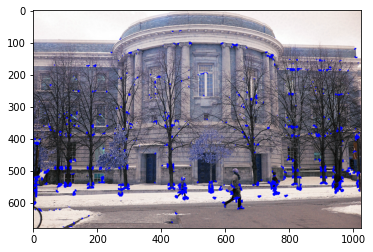

In [ ]:
plot(img1, threshold, lam0_img1_k2, lam1_img1_k2)

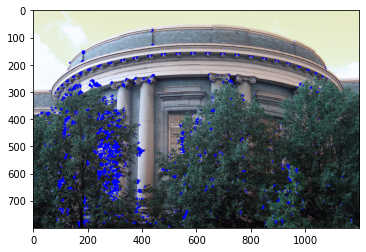

In [ ]:
plot(img2, threshold, lam0_img2_k2, lam1_img2_k2)

Q3.1


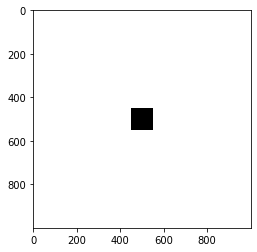

In [ ]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
sigma = 5
img = np.zeros([1000,1000,3],dtype=np.uint8)
img.fill(255) # or img[:] = 255
img[450:550, 450:550] = [0, 0, 0]
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
img = img[:][:]
def LoG(sigma):
    n = 1000 # filter size
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (1/(np.pi*sigma**2))*((x*x + y*y)/(2*sigma**2)-1) *  (x_filter*y_filter)
    return final_filter

184


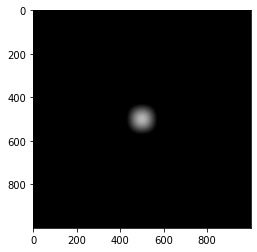

In [ ]:
sigma = 40
filter_log = LoG(sigma) #filter generation
laplacian = cv2.filter2D(img,-1,filter_log) # convolving image
print(np.amax(abs(laplacian)))
plt.imshow(laplacian)
plt.show()

